[Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import requests
import zipfile

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about *120 training images each for ants and bees.
There are 75 validation images for each class*. Usually, this is a very
small dataset to generalize upon, if trained from scratch.  

Since we are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [3]:
DATA_URL = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
DATA_PATH = os.path.join('.', 'data')
FILE_NAME = os.path.join(DATA_PATH, 'hymenoptera_data.zip')

if not os.path.isfile(FILE_NAME):
  print("Downloading the data...")
  os.makedirs('data', exist_ok=True)
  with requests.get(DATA_URL) as req:
    with open(FILE_NAME, 'wb') as f:
      f.write(req.content)
  if 200 <= req.status_code < 300:
    print("Download complete!")
  else:
    print("Download failed!")
else:
  print(FILE_NAME, "already exists, skipping download...")

with zipfile.ZipFile(FILE_NAME, 'r') as zip_ref:
  print("Unzipping...")
  zip_ref.extractall('data')

DATA_PATH = os.path.join(DATA_PATH, 'hymenoptera_data')

Download complete!
Unzipping...


In [4]:
#!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [5]:
#!ls sample_data

In [6]:
# # Unzip quietly 
# !unzip -q 'hymenoptera_data.zip'

# # View the unzipped contents in the virtual machine
# os.listdir()

In [11]:
# Check current directory (be sure you're in the directory where Colab operates: '/content')
os.getcwd()

'/content'

In [17]:
!ls data/hymenoptera_data/train

ants  bees


In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: data/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: data/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [ ]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f3a3e2f8910>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f3a3e2f8ed0>}

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
dataset_sizes, class_names

({'train': 244, 'val': 153}, ['ants', 'bees'])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

Visualize a few images  
^^^^^^^^^^^^^^^^^^^^^^^^  
Let's visualize a few training images so as to understand the data
augmentations.



In [ ]:
# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


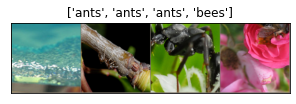

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
      """
      Support function for model training.

      Args:
        model: Model to be trained
        criterion: Optimization criterion (loss)
        optimizer: Optimizer to use for training
        scheduler: Instance of ``torch.optim.lr_scheduler``
        num_epochs: Number of epochs
        device: Device to run the training on. Must be 'cpu' or 'cuda'
      """
      since = time.time()

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0

      for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
          if phase == 'train':
            model.train()  # Set model to training mode
          else:
            model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
            scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f}'.format(best_acc))

      # load best model weights
      model.load_state_dict(best_model_wts)
      return model

Visualizing the model predictions  
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images

In [ ]:
def visualize_model(model, num_images=6, device='cpu'):
#def visualize_model(model, rows=3, cols=3, device='cpu'):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.

In [ ]:
# Load pretrained resnet18 model

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

In [ ]:
# Change output layer, here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

In [ ]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate  
^^^^^^^^^^^^^^^^^^^^  

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25, device=device)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6233 Acc: 0.7008
val Loss: 0.3273 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.4849 Acc: 0.7951
val Loss: 0.6331 Acc: 0.7647

Epoch 2/24
----------
train Loss: 0.4906 Acc: 0.7787
val Loss: 0.2484 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.3589 Acc: 0.8402
val Loss: 0.3307 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.6501 Acc: 0.7746
val Loss: 0.6432 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4897 Acc: 0.8197
val Loss: 0.5591 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.5252 Acc: 0.8279
val Loss: 0.3251 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.4710 Acc: 0.8320
val Loss: 0.2938 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.3594 Acc: 0.8402
val Loss: 0.2621 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3865 Acc: 0.8443
val Loss: 0.2896 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.3076 Acc: 0.8648
val Loss: 0.2610 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3379 Acc: 0.8320
val Loss: 0.2519 Acc: 0.8954

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


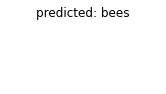

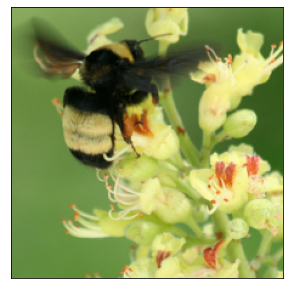

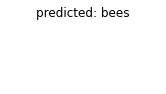

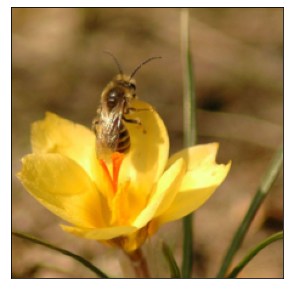

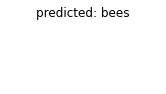

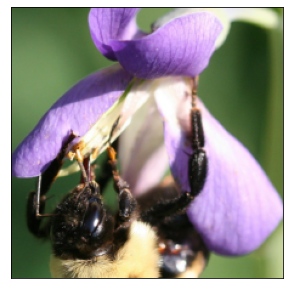

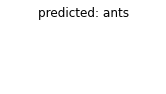

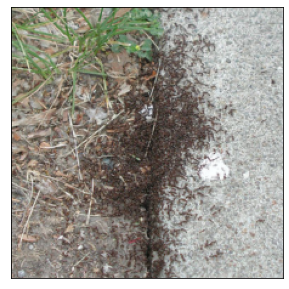

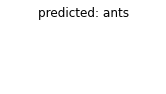

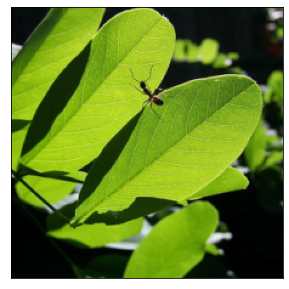

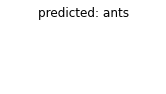

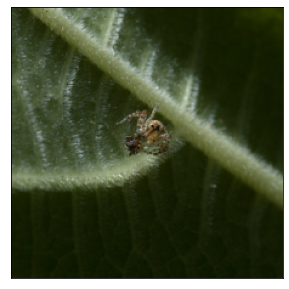

In [ ]:
visualize_model(model_ft, device=device)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.


In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

In [ ]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
num_ftrs

512

In [ ]:
model_conv.fc = nn.Linear(num_ftrs, 2)

In [ ]:
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate  
^^^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25, device=device)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6673 Acc: 0.6230
val Loss: 0.3056 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.5108 Acc: 0.7664
val Loss: 0.1802 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.3722 Acc: 0.8197
val Loss: 0.2589 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.5372 Acc: 0.7623
val Loss: 0.5183 Acc: 0.8105

Epoch 4/24
----------
train Loss: 0.7415 Acc: 0.7295
val Loss: 0.2257 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4885 Acc: 0.7992
val Loss: 0.3527 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.5341 Acc: 0.8197
val Loss: 0.1871 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3958 Acc: 0.8361
val Loss: 0.1905 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4155 Acc: 0.8033
val Loss: 0.1605 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.4067 Acc: 0.8156
val Loss: 0.1807 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3828 Acc: 0.8443
val Loss: 0.1965 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3841 Acc: 0.8238
val Loss: 0.1637 Acc: 0.9673

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


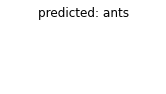

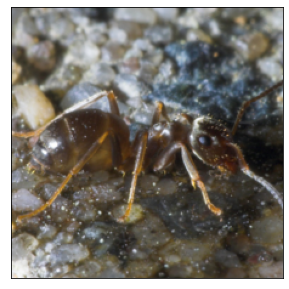

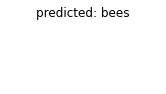

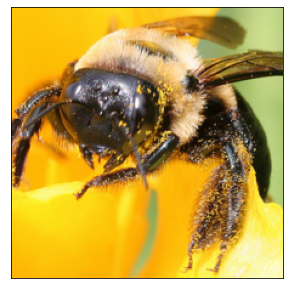

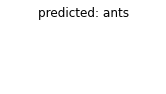

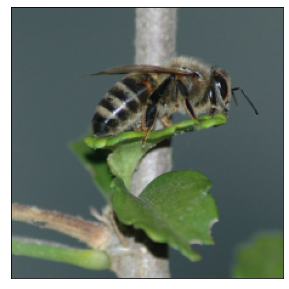

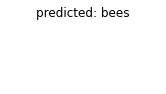

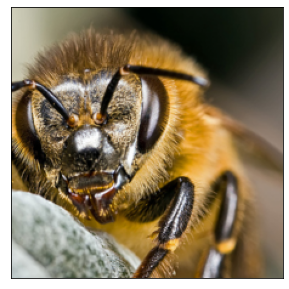

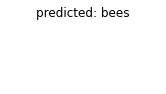

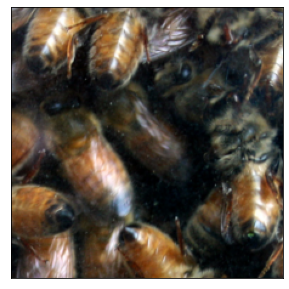

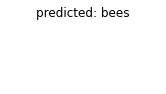

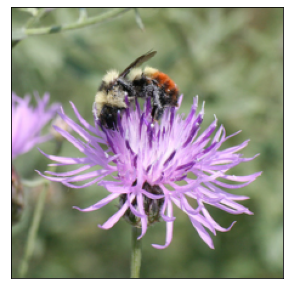

In [ ]:
visualize_model(model_conv, device=device)

plt.ioff()
plt.show()

# Quantized Transfer Learning


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Visualize a few images


Let's visualize a few training images so as to understand the data
augmentations.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


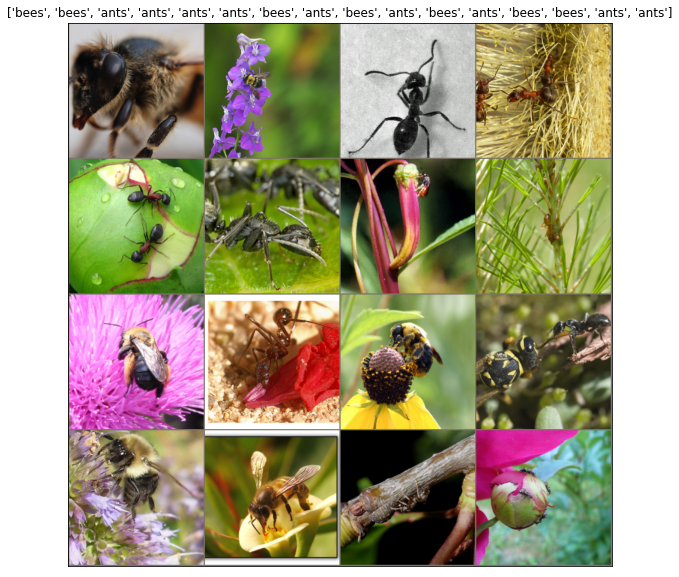

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

## Part 1. Training a Custom Classifier based on a Quantized Feature Extractor 

In this section you will use a “frozen” quantized feature extractor, and
train a custom classifier head on top of it. Unlike floating point
models, you don’t need to set requires_grad=False for the quantized
model, as it has no trainable parameters. Please, refer to the[documentation](https://pytorch.org/docs/stable/quantization.html) for
more details.

Load a pretrained model: for this exercise you will be using [ResNet-18](https://pytorch.org/hub/pytorch_vision_resnet/).

In [ ]:
import torchvision.models.quantization as models

# We will need the number of filters in the `fc` for future use.
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features

/usr/local/lib/python3.7/dist-packages/torch/quantization/observer.py:123: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


At this point you need to modify the pretrained model. The model
has the quantize/dequantize blocks in the beginning and the end. However,
because you will only use the feature extractor, the dequantizatioin layer has
to move right before the linear layer (the head). The easiest way to do that
is to wrap the model in the ``nn.Sequential`` module.

The first step is to isolate the feature extractor in the ResNet
model. Although in this example you are tasked to use all layers except
``fc`` as the feature extractor, in reality, you can take as many parts
as you need. This would be useful in case you would like to replace some
of the convolutional layers as well.

**Note:** When separating the feature extractor from the rest of a quantized
   model, you have to manually place the quantizer/dequantized in the
   beginning and the end of the parts you want to keep quantized.

The function below creates a model with a custom head.

In [ ]:
def create_combined_model(model_fe):
  # Step 1. Isolate the feature extractor.
  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model

Warning: Currently the quantized models can only be run on CPU. However, it is possible to send the non-quantized parts of the model to a GPU.

In [ ]:
new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

This step takes around 15-25 min on CPU. Because the quantized model can
only run on the CPU, you cannot run the training on GPU.

In [ ]:
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25, device='cpu')

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4495 Acc: 0.7992
val Loss: 0.2861 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5054 Acc: 0.8975
val Loss: 0.4121 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4357 Acc: 0.9098
val Loss: 0.3045 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.5038 Acc: 0.9016
val Loss: 0.8319 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5221 Acc: 0.9098
val Loss: 0.5624 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.4564 Acc: 0.9016
val Loss: 0.4460 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.6457 Acc: 0.8975
val Loss: 0.2894 Acc: 0.9673

Epoch 7/24
----------
train Loss: 0.3882 Acc: 0.9262
val Loss: 0.3089 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.3896 Acc: 0.9467
val Loss: 0.3505 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.1946 Acc: 0.9426
val Loss: 0.2997 Acc: 0.9673

Epoch 10/24
----------
train Loss: 0.2692 Acc: 0.9508
val Loss: 0.2910 Acc: 0.9673

Epoch 11/24
----------
train Loss: 0.2472 Acc: 0.9467
val Loss: 0.3020 Acc: 0.9673

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


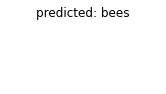

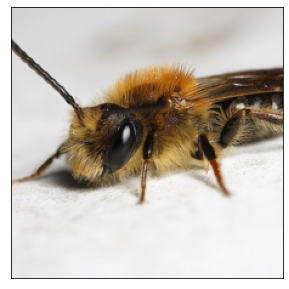

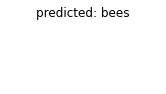

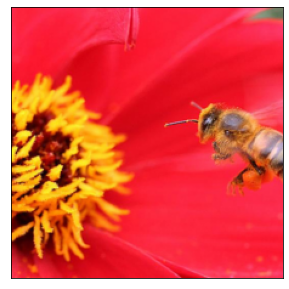

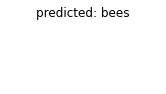

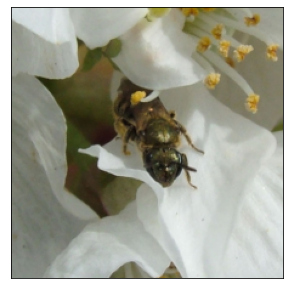

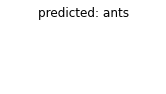

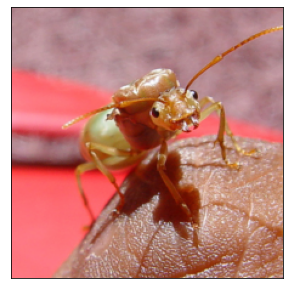

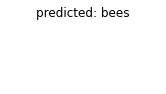

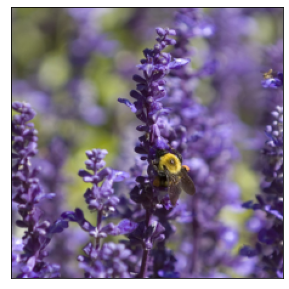

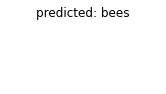

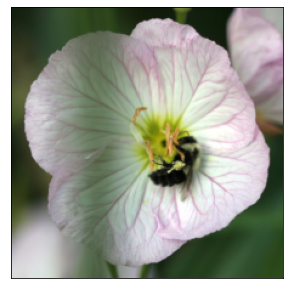

<Figure size 432x288 with 0 Axes>

In [ ]:
visualize_model(new_model)
plt.tight_layout()

## Part 2. Finetuning the Quantizable Model


In this part, we fine tune the feature extractor used for transfer
learning, and quantize the feature extractor. Note that in both part 1
and 2, the feature extractor is quantized. The difference is that in
part 1, we use a pretrained quantized model. In this part, we create a
quantized feature extractor after fine tuning on the data-set of
interest, so this is a way to get better accuracy with transfer learning
while having the benefits of quantization. Note that in our specific
example, the training set is really small (120 images) so the benefits
of fine tuning the entire model is not apparent. However, the procedure
shown here will improve accuracy for transfer learning with larger
datasets.

The pretrained feature extractor must be quantizable.
To make sure it is quantizable, perform the following steps:

 1. Fuse ``(Conv, BN, ReLU)``, ``(Conv, BN)``, and ``(Conv, ReLU)`` using
    ``torch.quantization.fuse_modules``.
 2. Connect the feature extractor with a custom head.
    This requires dequantizing the output of the feature extractor.
 3. Insert fake-quantization modules at appropriate locations
    in the feature extractor to mimic quantization during training.

For step (1), we use models from ``torchvision/models/quantization``, which
have a member method ``fuse_model``. This function fuses all the ``conv``,
``bn``, and ``relu`` modules. For custom models, this would require calling
the ``torch.quantization.fuse_modules`` API with the list of modules to fuse
manually.

Step (2) is performed by the ``create_combined_model`` function
used in the previous section.

Step (3) is achieved by using ``torch.quantization.prepare_qat``, which
inserts fake-quantization modules.


As step (4), you can start "finetuning" the model, and after that convert
it to a fully quantized version (Step 5).

To convert the fine tuned model into a quantized model you can call the
``torch.quantization.convert`` function (in our case only
the feature extractor is quantized).

**Note:** Because of the random initialization your results might differ from
   the results shown in this tutorial.

In [ ]:
# notice `quantize=False`
model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features

# Step 1
model.train()
model.fuse_model()
# Step 2
model_ft = create_combined_model(model)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig  # Use default QAT configuration
# Step 3
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

/usr/local/lib/python3.7/dist-packages/torch/quantization/observer.py:123: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


### Finetuning the model

In the current tutorial the whole model is fine tuned. In
general, this will lead to higher accuracy. However, due to the small
training set used here, we end up overfitting to the training set.


Step 4. Fine tune the model


In [ ]:
for param in model_ft.parameters():
  param.requires_grad = True

model_ft.to(device)  # We can fine-tune on GPU if available

criterion = nn.CrossEntropyLoss()

# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.3 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                              num_epochs=25, device=device)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7315 Acc: 0.6148
val Loss: 0.3181 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.3204 Acc: 0.8525
val Loss: 0.2070 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.2016 Acc: 0.9426
val Loss: 0.1795 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.1506 Acc: 0.9508
val Loss: 0.1616 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.1474 Acc: 0.9426
val Loss: 0.1798 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.0829 Acc: 0.9713
val Loss: 0.1836 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.0896 Acc: 0.9754
val Loss: 0.1743 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.0706 Acc: 0.9877
val Loss: 0.1748 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.1189 Acc: 0.9590
val Loss: 0.1775 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.0872 Acc: 0.9713
val Loss: 0.1758 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.0711 Acc: 0.9795
val Loss: 0.1627 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.0810 Acc: 0.9795
val Loss: 0.1638 Acc: 0.9346

Epoch 12/24
----------
t

Step 5. Convert to quantized model

In [ ]:
from torch.quantization import convert
model_ft_tuned.cpu()

model_quantized_and_trained = convert(model_ft_tuned, inplace=False)

Lets see how the quantized model performs on a few images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


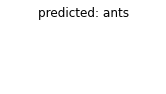

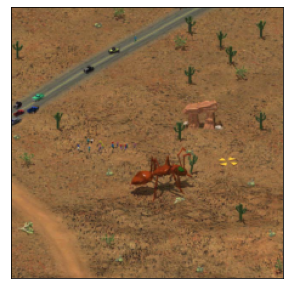

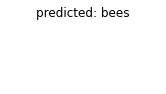

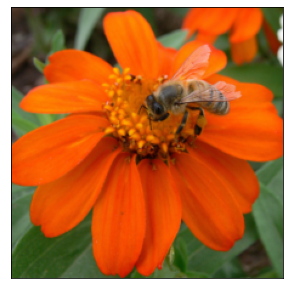

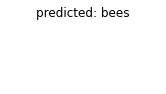

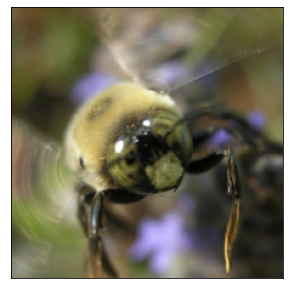

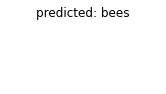

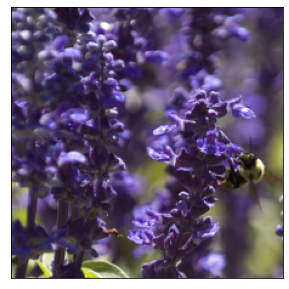

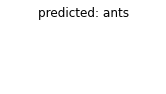

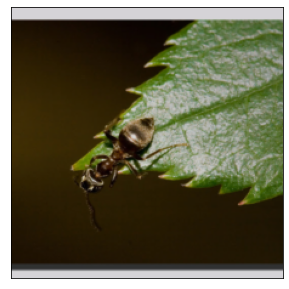

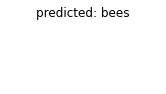

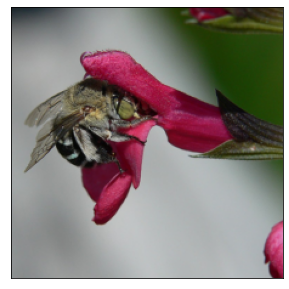

<Figure size 432x288 with 0 Axes>

In [ ]:
visualize_model(model_quantized_and_trained)

plt.ioff()
plt.tight_layout()
plt.show()